In [1]:
import pandas as pd
import random
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
codon_aa={'UUU':'Phe','UUC':'Phe','UUA':'Leu','UUG':'Leu','CUU':'Leu','CUC':'Leu','CUA':'Leu','CUG':'Leu','AUU':'Ile',
       'AUC':'Ile','AUA':'Ile','AUG':'Met','GUU':'Val','GUC':'Val','GUA':'Val','GUG':'Val','UCU':'Ser','UCC':'Ser',
       'UCA':'Ser','UCG':'Ser','CCU':'Pro','CCC':'Pro','CCA':'Pro','CCG':'Pro','ACU':'Thr','ACC':'Thr','ACA':'Thr',
       'ACG':'Thr','GCU':'Ala','GCC':'Ala','GCA':'Ala','GCG':'Ala','UAU':'Tyr','UAC':'Tyr','UAA':'STOP','UAG':'STOP',
       'CAU':'His','CAC':'His','CAA':'Gln','CAG':'Gln','AAU':'Asn','AAC':'Asn','AAA':'Lys','AAG':'Lys','GAU':'Asp',
       'GAC':'Asp','GAA':'Glu','GAG':'Glu','UGU':'Cys','UGC':'Cys','UGA':'STOP','UGG':'Trp','CGU':'Arg','CGC':'Arg',
       'CGA':'Arg','CGG':'Arg','AGU':'Ser','AGC':'Ser','AGA':'Arg','AGG':'Arg','GGU':'Gly','GGC':'Gly','GGA':'Gly',
       'GGG':'Gly'}

In [3]:
aa_counter = {
    'Pro' : [],
    'Ser' : [],
    'Ala' : [],
    'Thr' : [],
    'Leu' : [],
    'Phe' : [],
    'Val' : [],
    'Ile' : [],
    'Met' : [],
    'Arg' : [],
    'Cys' : [],
    'Trp' : [],
    'Gly' : [],
    'His' : [],
    'Gln' : [],
    'Tyr' : [],
    'Asp' : [],
    'Glu' : [],
    'Asn' : [],
    'Lys' : []
}

In [4]:
ref_data = pd.read_csv('../data/U_ideal_table.csv', index_col=0)

C:\Users\voron\AppData\Local\Temp\ipykernel_20156\1864407084.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  ref_data = pd.read_csv('../data/U_ideal_table.csv', index_col=0)


In [5]:
ref_data = ref_data[ref_data['GenType'] == 'translated']

In [6]:
ref_data = ref_data[['CodonNumber', 'RefCodon']].drop_duplicates()

In [7]:
ref_data = ref_data[~(ref_data['RefCodon'].isin(['UGA', 'UAA', 'UAG']))]

In [8]:
ref_codon_list = ref_data['RefCodon'].to_list()

In [9]:
mutations = pd.read_csv('../data/All_mutation_information.csv.gz')
mutations = mutations[mutations['(SBS) is coding'].isin([True, 'TRUE', 'TRUE, TRUE'])]

C:\Users\voron\AppData\Local\Temp\ipykernel_20156\1688172839.py:1: DtypeWarning: Columns (13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations = pd.read_csv('../data/All_mutation_information.csv.gz')


In [10]:
all_df = mutations[mutations['base(s) in status 1'].isin(['A', 'T', 'G', 'C']) & mutations['base(s) in status 2'].isin(['A', 'T', 'G', 'C'])]

all_df['aa_from'] = all_df['(SBS) AA change'].str.split(" ").str[1].str[0]
all_df['aa_to'] = all_df['(SBS) AA change'].str.split(" ").str[1].str[0]
all_df = all_df.reset_index(drop=True)
all_df['counter'] = all_df.index
all_df['from_to_nuc'] = all_df['base(s) in status 1'] + '>' + all_df['base(s) in status 2']
data = all_df[['from_to_nuc', 'counter']].groupby(['from_to_nuc'], as_index=False).count()
n_mut = int(sum(data['counter']))
max_mut = int(max(data['counter']))
data['counter'] = data['counter']/n_mut

In [11]:
data['from_nuc'] = data['from_to_nuc'].str.split(">").str[0]
data['to_nuc'] = data['from_to_nuc'].str.split(">").str[1]
data['to_nuc'] = data['to_nuc'].str.replace('T','U')
data['from_nuc'] = data['from_nuc'].str.replace('T','U')

In [12]:
data

,from_to_nuc,counter,from_nuc,to_nuc
0,A>C,0.014415,A,C
1,A>G,0.088633,A,G
2,A>T,0.017136,A,U
3,C>A,0.021710,C,A
4,C>G,0.003897,C,G
5,C>T,0.468641,C,U
6,G>A,0.072942,G,A
7,G>C,0.012941,G,C
8,G>T,0.178431,G,U
9,T>A,0.013295,U,A


In [13]:
def select_codon_number(codon_list):
    return random.choice(range(len(codon_list)))

In [14]:
def mutate_codon(codon_number):
    nuc_number = random.choice(range(len(codon_list[codon_number])))
    
    nuc_spec = data[data['from_nuc'] == codon_list[codon_number][nuc_number]]
    pop = nuc_spec['to_nuc'].to_list()
    pop.append(codon_list[codon_number][nuc_number])
    
    wei = nuc_spec['counter'].to_list()
    wei.append(1 - sum(wei))
    
    new_nuc = random.choices(pop, weights=wei)[0]
    
    new_codon = codon_list[codon_number][:nuc_number] + new_nuc + codon_list[codon_number][nuc_number + 1:]
    
    if new_codon in ['UGA', 'UAA', 'UAG']:
        new_codon = codon_list[codon_number]
    
    codon_list[codon_number] = new_codon

In [15]:
def update_aa_dict(aa_counter, new_aa_counter):
    for key in aa_counter.keys():
        if key in new_aa_counter.keys():
            aa_counter[key].append(new_aa_counter[key])
        else:
            aa_counter[key].append(0)

In [17]:
codon_list = ref_codon_list

num_generations = 10000
mut_in_gen = 100

for gen in tqdm(range(num_generations)):
    new_dict = dict(Counter([codon_aa.get(item, item)  for item in codon_list]))
    
    update_aa_dict(aa_counter, new_dict)
    for mut in range(mut_in_gen):
        codon_num_to_mut = select_codon_number(codon_list)
        
        mutate_codon(codon_num_to_mut)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:23<00:00, 38.02it/s]


In [18]:
mutated_df = pd.DataFrame(aa_counter)
mutated_df = mutated_df / len(ref_codon_list)

In [19]:
mutated_df

,Pro,Ser,Ala,Thr,Leu,Phe,Val,Ile,Met,Arg,Cys,Trp,Gly,His,Gln,Tyr,Asp,Glu,Asn,Lys
0,0.040456,0.067871,0.067563,0.073724,0.095492,0.051340,0.080193,0.052572,0.021152,0.035835,0.030393,0.011397,0.059144,0.019407,0.037478,0.046001,0.052469,0.045282,0.054523,0.057706
1,0.040353,0.067666,0.067358,0.073622,0.095595,0.051340,0.080501,0.052572,0.021255,0.035835,0.030496,0.011397,0.059144,0.019509,0.037376,0.046001,0.052469,0.045282,0.054523,0.057706
2,0.040045,0.067974,0.067255,0.073622,0.095390,0.051648,0.080398,0.052675,0.021255,0.035938,0.030496,0.011397,0.059144,0.019509,0.037170,0.046001,0.052367,0.045282,0.054626,0.057809
3,0.040251,0.067871,0.067153,0.073416,0.095287,0.051853,0.080398,0.052777,0.021357,0.035938,0.030393,0.011397,0.059246,0.019509,0.037067,0.046103,0.052264,0.045282,0.054626,0.057809
4,0.040148,0.067871,0.067153,0.073313,0.095390,0.051956,0.080398,0.052983,0.021357,0.035938,0.030393,0.011295,0.059452,0.019509,0.037067,0.046001,0.052367,0.045179,0.054420,0.057809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10734,0.017661,0.097443,0.010576,0.019817,0.178458,0.322928,0.050108,0.095082,0.007906,0.013964,0.043844,0.002772,0.008214,0.015813,0.004929,0.072492,0.009344,0.004826,0.018482,0.005339
10735,0.017661,0.097238,0.010576,0.019817,0.178868,0.322518,0.050005,0.095184,0.008009,0.014067,0.043947,0.002772,0.008214,0.015813,0.004929,0.072389,0.009344,0.004826,0.018482,0.005339
10736,0.017661,0.097341,0.010576,0.019817,0.179074,0.322312,0.050005,0.095184,0.008009,0.013964,0.043947,0.002772,0.008214,0.015813,0.004929,0.072389,0.009344,0.004826,0.018482,0.005339
10737,0.017661,0.096827,0.010576,0.020023,0.179485,0.322312,0.050005,0.094979,0.008112,0.013862,0.043947,0.002772,0.008214,0.015813,0.004929,0.072389,0.009344,0.004826,0.018585,0.005339


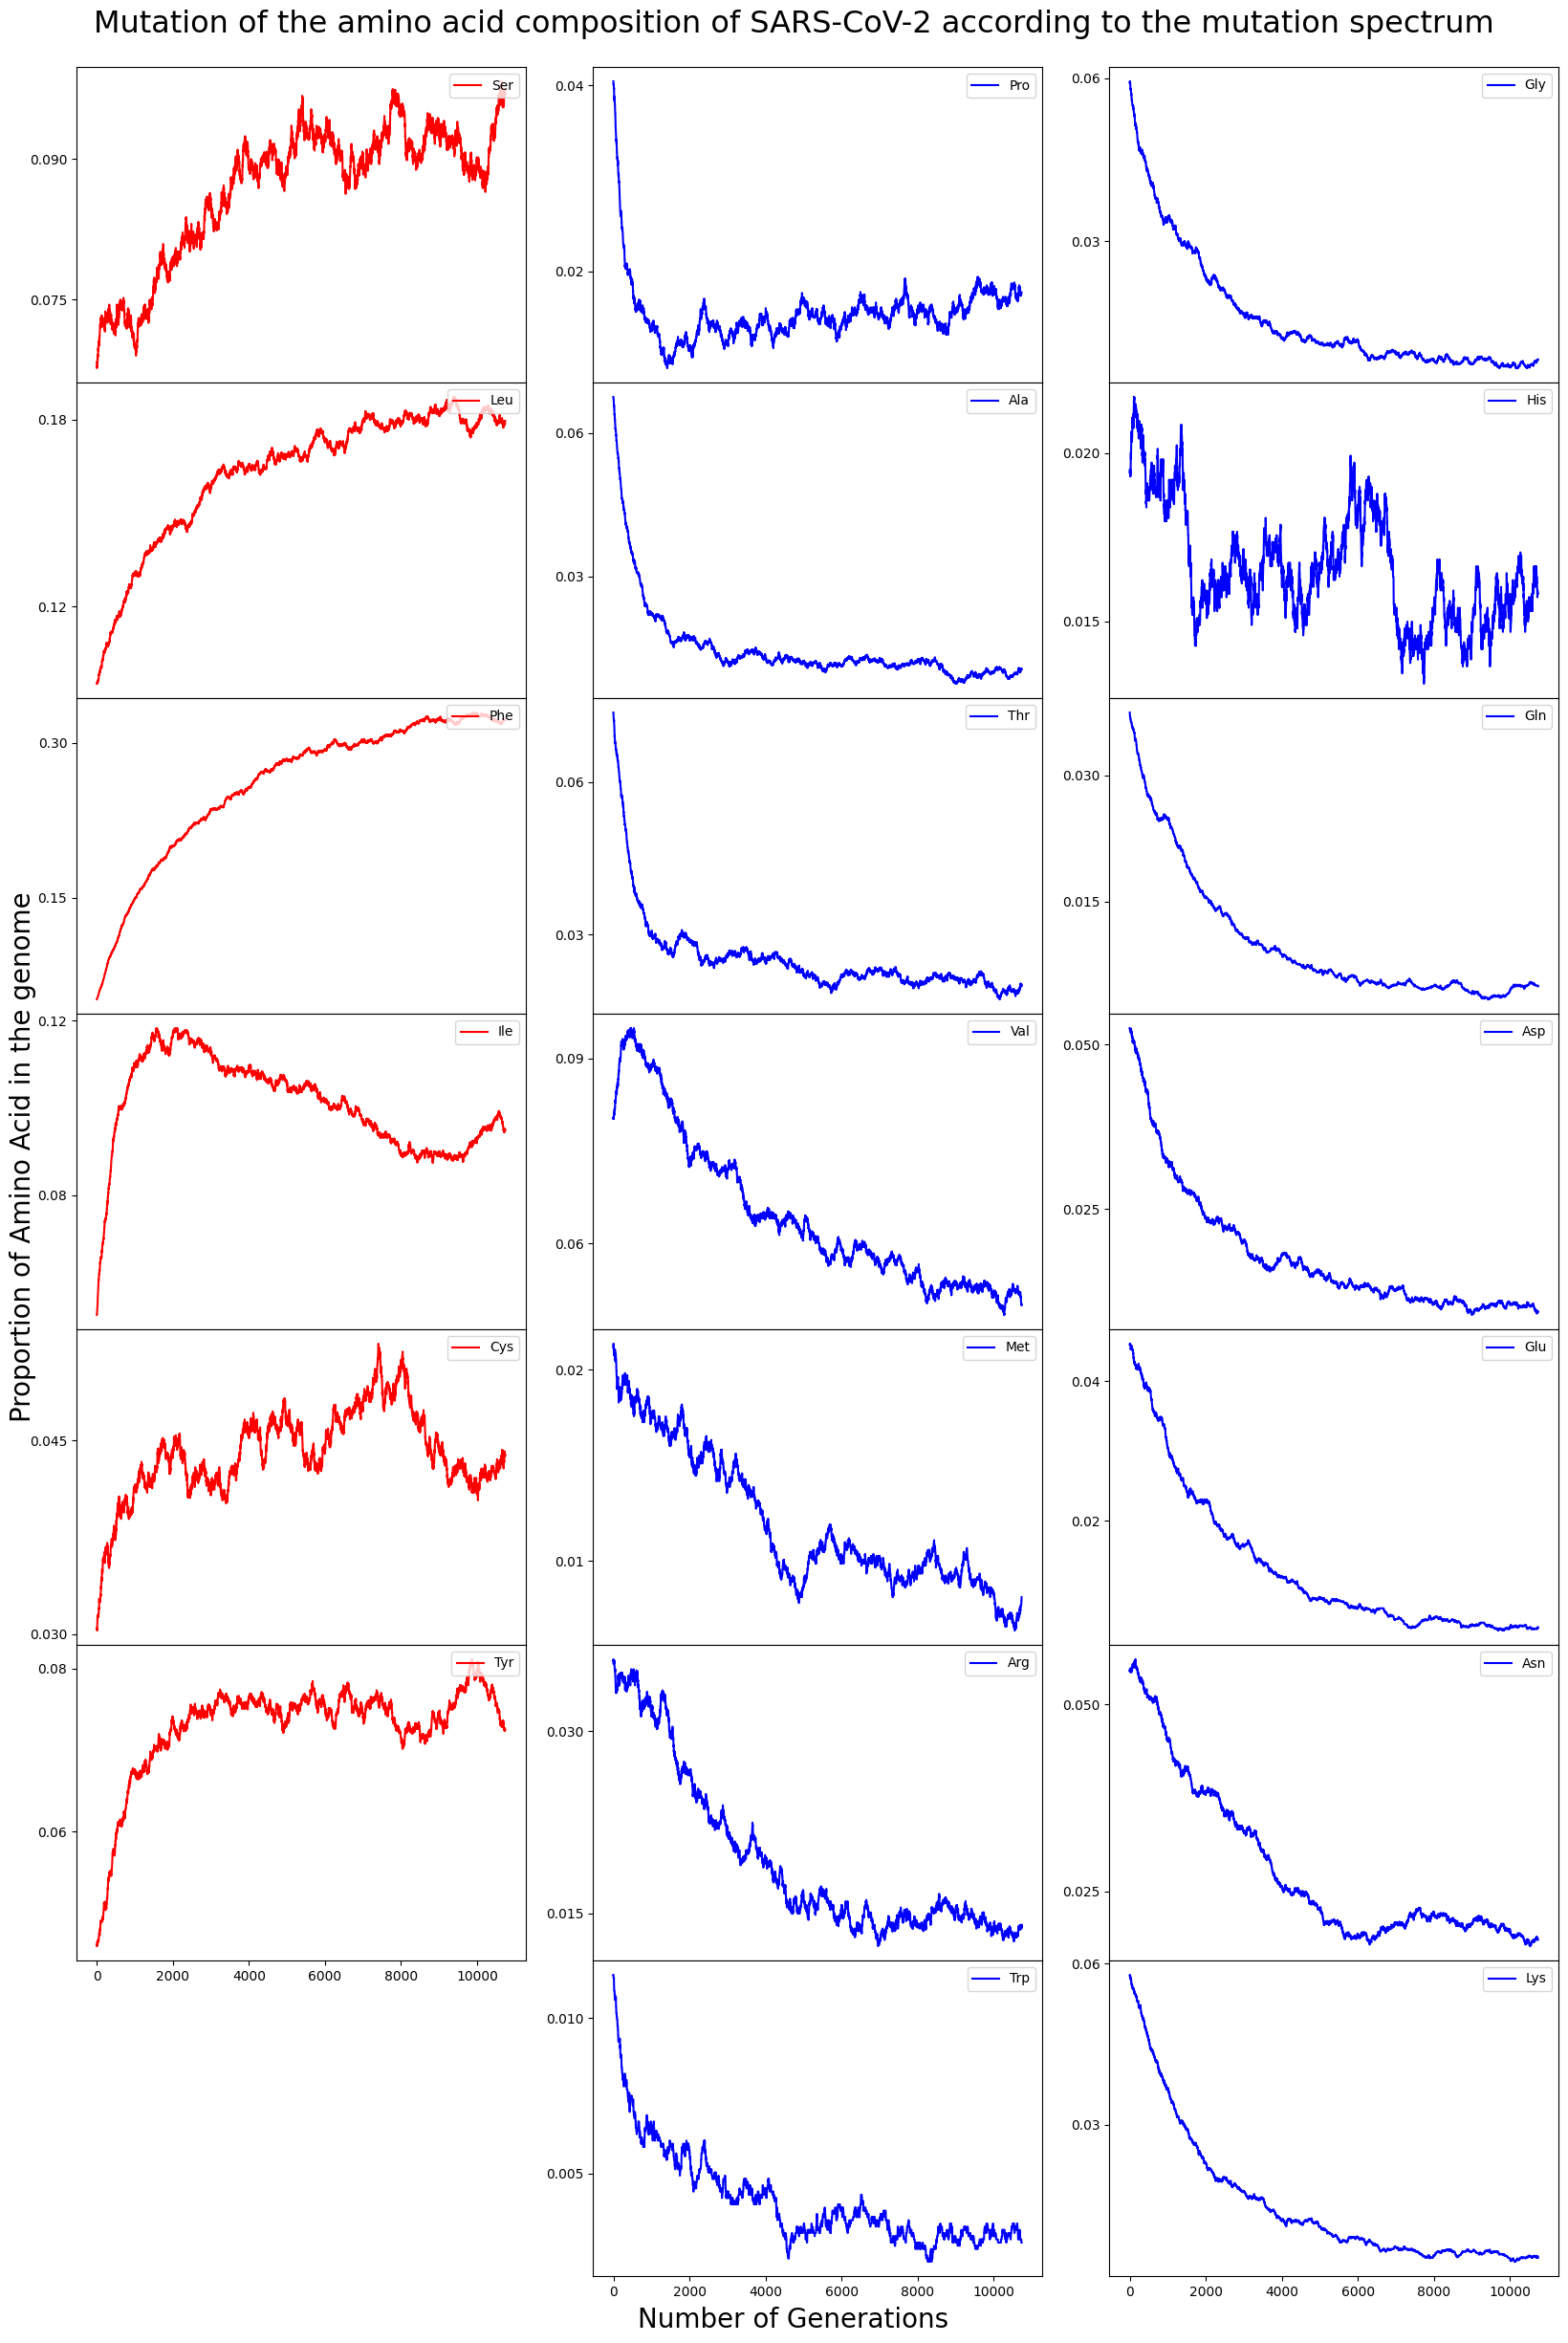

In [42]:
gainers = ['Ser', 'Leu', 'Phe', 'Ile', 'Cys', 'Tyr']
loosers = ['Pro', 'Ala', 'Thr', 'Val', 'Met', 'Arg', 'Trp', 'Gly', 'His', 'Gln', 'Asp', 'Glu', 'Asn', 'Lys']
with PdfPages('../figures/mutation_of_aa.pdf') as pdf:
    fig, axs = plt.subplots(7, 3, figsize=(20, 30))

    for aa_num in range(len(loosers)):
        if aa_num <= 6:
            first = aa_num
            second = 1
        else:
            first = aa_num - 7
            second = 2
        aa = loosers[aa_num]
        if aa in gainers:
            axs[first][second].plot(mutated_df[aa], color='red', label=aa)
        elif aa in loosers:
            axs[first][second].plot(mutated_df[aa], color='blue', label=aa)
        else:
            axs[first][second].plot(mutated_df[aa], color='black', label=aa)

        axs[first][second].legend(loc="upper right")
        axs[first][second].yaxis.set_major_locator(plt.MaxNLocator(2))
        
    for aa_num in range(len(gainers)):
        aa = gainers[aa_num]
        if aa in gainers:
            axs[aa_num][0].plot(mutated_df[aa], color='red', label=aa)
        elif aa in loosers:
            axs[aa_num][0].plot(mutated_df[aa], color='blue', label=aa)
        else:
            axs[aa_num][0].plot(mutated_df[aa], color='black', label=aa)

        axs[aa_num][0].legend(loc="upper right")
        axs[aa_num][0].yaxis.set_major_locator(plt.MaxNLocator(2))
        
    
    plt.subplots_adjust(hspace=0)
    plt.subplots_adjust(wspace=0.15)
    axs[6,0].set_axis_off()
        
    plt.grid(False)
    fig.supylabel("Proportion of Amino Acid in the genome", x=0.09, size=20)
    fig.supxlabel("Number of Generations", y=0.09, size=20)
    fig.suptitle("Mutation of the amino acid composition of SARS-CoV-2 according to the mutation spectrum", y=0.90, size=23)
    pdf.savefig(fig, bbox_inches='tight') 